### Numba Python Classical XY-Model

The equations:


$F[\vec \phi]=\int d^2x[(\nabla \vec \phi)^2+V_0(\vec \phi ^2 - 1)^2]$

$\partial _ t \vec \phi = -\Gamma \delta F / \delta \vec \phi$

$ \langle \vec \phi (x,0)\cdot \vec \phi (x',0) \rangle = \Delta \delta (x-x')$


The actual equation that I end up solving:

$\frac {d \vec \phi}{dt} = - \Gamma ( V_0 2 \vec \phi (\vec \phi ^2 - 1) - 2 \nabla ^2 \vec \phi)$

I do this for x and y (two seperate equations) with backwards euler 5-point gradiant stencil as numerical scheme.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numba import njit, prange
import os
import imageio.v2 as imageio
from IPython.display import Image, display, HTML
import time
from skimage.feature import peak_local_max
from scipy.optimize import curve_fit
from natsort import natsorted

In [2]:
# Constants

# The interesting physics parameter :)
V_0 = 0.1
# Kinetic coefficient (timescale) should be less than or equal to 1 
Gamma = 0.5
# Determines the order of the initial state (not used)
Delta = 1
# Scalar
s = 1
# Size of lattice
N = 256
M = N
# Time step
dt = 0.01
# Amount of timesteps I want the simulation to run in units: number divided by size of dt
T = 1
# Seed to reproduce the randomization
np.random.seed(69420)
# Determines interval between images saved for plotting
step_interval = 10

In [3]:
# Function that initializes a field
# N and M can't currently be different because angle_field and scalar_field only uses M
@njit
def create_vector_field(N, M):
    vector_field = np.empty((N, M, 2))
    for i in range(N):
        for j in range(M):
            angle = np.random.uniform(0, 2 * np.pi)
            vector_field[i, j, 0] = s * np.cos(angle)
            vector_field[i, j, 1] = s * np.sin(angle)
    return vector_field

vector_matrix = create_vector_field(N, M)
#print("Vector configuration:", vector_matrix)
# print(vector_matrix[0,0])
# print(vector_matrix[4,4])

In [4]:
# Function that calulates the angles of a field
@njit
def angle_from_field(vector_field):
    angle_field = np.empty((N, M))
    for i in range(N):
        for j in range(M):
            angle_field[i, j] = np.arctan2(vector_field[i, j, 1]/s, vector_field[i, j, 0]/s)
    return angle_field

# Function that calulates the scalars of a field
@njit
def scalar_from_field(vector_field):
    scalar_field = np.empty((N, M))
    for i in range(N):
        for j in range(M):
            scalar_field[i, j] = np.sqrt(vector_field[i, j, 0] ** 2 + vector_field[i, j, 1] ** 2)
    return scalar_field

#print("Angles:", angle_from_field(vector_matrix))
#print("Scalars:", scalar_from_field(vector_matrix))

In [5]:
# Code that plots the starting configuration

# fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# # Plots the angles
# initial_angles = angle_from_field(vector_matrix)
# im1 = axs[0].imshow(initial_angles, origin='lower', cmap='hsv', vmin=-np.pi, vmax=np.pi)
# axs[0].set_title("Angles of starting configuration")
# fig.colorbar(im1, ax=axs[0])

# # Plots the scalars
# initial_scalars = scalar_from_field(vector_matrix)
# im2 = axs[1].imshow(initial_scalars, origin='lower', cmap='inferno', vmin=0, vmax=1)
# axs[1].set_title("Scalars of starting configuration")
# fig.colorbar(im2, ax=axs[1])

# plt.tight_layout()
# plt.show()

# #print(vector_matrix[0,0])

In [6]:
# Computes next time step
@njit
def compute_next_step(vector_field, dt):
    derivative = vector_field_derivative(vector_field.copy())
    vector_field_next_step = vector_field + dt * derivative
    # Vector_field += dt * derivative
    return vector_field_next_step

# Gets angles and scalars from time step
@njit
def compute_fields(vector_field):
    angle_field = angle_from_field(vector_field.copy())
    scalar_field = scalar_from_field(vector_field.copy())
    return vector_field.copy(), angle_field, scalar_field

In [7]:
@njit(parallel=True)
def vector_field_derivative(vector_field):
    vector_field_derived = np.zeros_like(vector_field)
    for i in prange(N):
        for j in prange(M):
            up = (i - 1) % N
            down = (i + 1) % N
            left = (j - 1) % M
            right = (j + 1) % M
            
            non_linear_term = V_0 * 2 * vector_field[i, j] * ((vector_field[i, j, 0] ** 2 + vector_field[i, j, 1] ** 2) - 1)
            laplacian_term = ((vector_field[up, j] + vector_field[down, j] + vector_field[i, left] + vector_field[i, right]) - 4 * vector_field[i, j]) / 1
            
            vector_field_derived[i, j] = -Gamma * (non_linear_term - 2 * laplacian_term)
    
    return vector_field_derived

In [8]:
# Runs the simulation in time
def time_derivative(vector_field, dt, T):
    os.makedirs("vector_field_iterations", exist_ok=True)
    os.makedirs("angle_field_iterations", exist_ok=True)
    os.makedirs("scalar_field_iterations", exist_ok=True)
    
    t = np.arange(0, T, dt)
    
    for i in range(len(t)):
        #vector_field = compute_next_step(vector_field.copy(), dt)
        vector_field = compute_next_step(vector_field.copy(), dt)
        vector_field_iteration, angle_field, scalar_field = compute_fields(vector_field.copy())
        
        np.save(f"vector_field_iterations/vector_field_iteration_{i}.npy", vector_field.copy())
        np.save(f"angle_field_iterations/angle_field_{i}.npy", angle_field.copy())
        np.save(f"scalar_field_iterations/scalar_field_{i}.npy", scalar_field.copy())

    return ["vector_field_iterations", "angle_field_iterations", "scalar_field_iterations"]

t0 = time.time()
vector_matrix_simulation = time_derivative(vector_matrix, dt, T)
t1 = time.time()
total_time = t1-t0
print(total_time)

3.0668723583221436


In [9]:
# Detects peaks to count defects

defect_counts = []

for filename in natsorted(os.listdir("scalar_field_iterations")):
    scalar_field = np.load(os.path.join("scalar_field_iterations", filename))
    
    coordinates = peak_local_max(-scalar_field + 1, min_distance=3, threshold_rel=0.5, exclude_border=False)
    num_defects = len(coordinates)
    
    defect_counts.append(num_defects)

t2 = time.time()
second_timing_part = t2-t1
print(second_timing_part)

2.2895493507385254


### Code that saves the simulation as images and GIFs to display

In [10]:
# # Defines the diretories where our images end up
# output_dirs = ['angle_field_images', 'scalar_field_images']
# for dir in output_dirs:
#     os.makedirs(dir, exist_ok=True)

# # Gets lists of files in the directories
# angle_files = natsorted(os.listdir("angle_field_iterations"))
# scalar_files = natsorted(os.listdir("scalar_field_iterations"))

# # Iterates over the files and save plots
# for i in range(0, len(angle_files), step_interval):
#     angle_field = np.load(os.path.join("angle_field_iterations", angle_files[i]))
#     scalar_field = np.load(os.path.join("scalar_field_iterations", scalar_files[i]))

#     # Saves the angle field image
#     plt.figure(figsize=(5, 5))
#     plt.imshow(angle_field, cmap='hsv', interpolation='none', origin='lower', vmin=-np.pi, vmax=np.pi)
#     plt.colorbar()
#     plt.title(f'Angles for time step {i}')
#     plt.savefig(f'angle_field_images/angle_field_{i:03d}.png')
#     plt.close()

#     # Saves the scalar field image
#     plt.figure(figsize=(5, 5))
#     plt.imshow(scalar_field, cmap='inferno', interpolation='none', origin='lower', vmin=0, vmax=1)
#     plt.colorbar()
#     plt.title(f'Scalars for time step {i}')
#     plt.savefig(f'scalar_field_images/scalar_field_{i:03d}.png')
#     plt.close()

In [11]:
# # Function to create GIF from images
# def create_gif(image_folder, gif_filename, duration=0.1):
#     images = []
#     image_files = sorted(os.listdir(image_folder))

#     for image_file in image_files:
#         filename = os.path.join(image_folder, image_file)
#         images.append(imageio.imread(filename))
        
#     imageio.mimsave(gif_filename, images, duration=duration)

# # Create GIFs
# create_gif('angle_field_images', 'angle_field_animation.gif')
# create_gif('scalar_field_images', 'scalar_field_animation.gif')

In [12]:
# # Display GIFs side by side
# display(HTML("""
# <div style="display: flex; justify-content: flex-start; align-items: center;">
#     <img src="angle_field_animation.gif" alt="Angle Field Animation" style="margin: 0; padding: 0; width: 49%;">
#     <img src="scalar_field_animation.gif" alt="Scalar Field Animation" style="margin: 0; padding: 0; width: 49%;">
# </div>
# """))

### Data gathered by running the code with different constants followed by data analysis

In [13]:
#np.save('V_0_values.npy', np.array([0.1, 1/3, 1, 10/3, 10, 100/3, 100]))
#np.save('defect_counts_01.npy', np.array(defect_counts))

#For dt=0.01, T=1000, Gamma=0.5, N=256
V_0_values = np.load('V_0_values.npy')
#print(V_0_values)
defect_counts_01 = np.load('defect_counts_01.npy')
defect_counts_03 = np.load('defect_counts_03.npy')
defect_counts_1 = np.load('defect_counts_1.npy')
defect_counts_3 = np.load('defect_counts_3.npy')
# defect_counts_10 = np.load('defect_counts_10.npy')
# defect_counts_33 = np.load('defect_counts_33.npy')
# defect_counts_100 = np.load('defect_counts_100.npy')

In [14]:
# Define the number of points to remove
points_to_remove = 300

# Remove the first 300 points from defect_counts and adjust the time steps accordingly
filtered_defect_counts = defect_counts[points_to_remove:]
filtered_defect_counts_01 = defect_counts_01[points_to_remove:]
filtered_defect_counts_03 = defect_counts_03[points_to_remove:]
filtered_defect_counts_1 = defect_counts_1[points_to_remove:]
filtered_defect_counts_3 = defect_counts_3[points_to_remove:]
# filtered_defect_counts_11 = defect_counts_11[points_to_remove:]
filtered_time_steps = np.arange(points_to_remove * step_interval, len(defect_counts_01) * step_interval, step_interval)
filtered_time = filtered_time_steps * dt

In [15]:
# Function to calculate R^2
def R_squared(observed, predicted):
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    R_squared = 1 - (ss_res / ss_tot)
    return R_squared

In [16]:
# Simpel model
def simple_model(x, a):
    return a/x

In [30]:
# log fit
def log_model(x, a, b):
    return a/x + np.log(x)

In [31]:
params_log_01, _ = curve_fit(log_model, filtered_time, filtered_defect_counts_01, p0=[1.0, 1.0], maxfev=2000)
fit_log_01 = log_model(filtered_time, *params_log_01)
R_squared_log_01 = R_squared(filtered_defect_counts_01, fit_log_01)

params_log_03, _ = curve_fit(log_model, filtered_time, filtered_defect_counts_03, p0=[1.0, 1.0], maxfev=2000)
fit_log_03 = log_model(filtered_time, *params_log_03)
R_squared_log_03 = R_squared(filtered_defect_counts_03, fit_log_03)

params_log_1, _ = curve_fit(log_model, filtered_time, filtered_defect_counts_1, p0=[1.0, 1.0], maxfev=2000)
fit_log_1 = log_model(filtered_time, *params_log_1)
R_squared_log_1 = R_squared(filtered_defect_counts_1, fit_log_1)

In [19]:
#print(params_log_1)

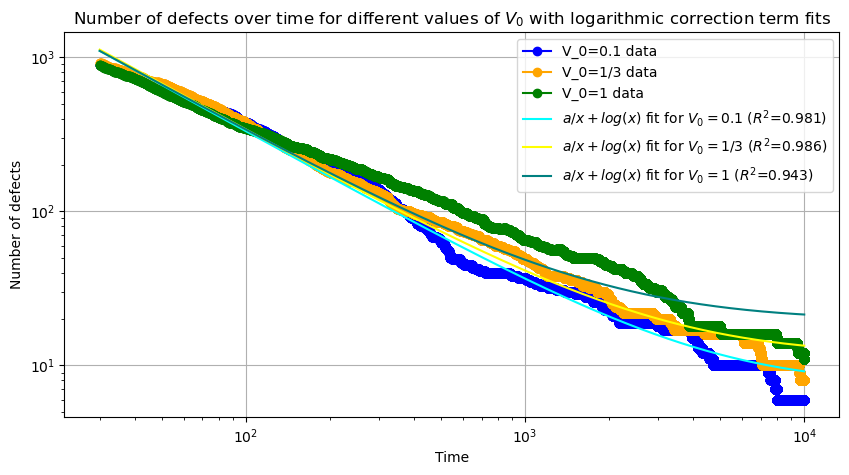

In [32]:
# Plot the number of defects over time
plt.figure(figsize=(10, 5))
# plt.plot(filtered_time_steps, filtered_defect_counts, marker='o', label='Current simulation')
plt.plot(filtered_time, filtered_defect_counts_01, color='blue', marker='o', label='V_0=0.1 data')
plt.plot(filtered_time, filtered_defect_counts_03, color='orange', marker='o', label='V_0=1/3 data')
plt.plot(filtered_time, filtered_defect_counts_1, color='green', marker='o', label='V_0=1 data')
plt.plot(filtered_time, fit_log_01, color='cyan', label=fr'$a/x+log(x)$ fit for $V_0=0.1$ ($R^2$={R_squared_log_01:.3f})')
plt.plot(filtered_time, fit_log_03, color='yellow', label=fr'$a/x+log(x)$ fit for $V_0=1/3$ ($R^2$={R_squared_log_03:.3f})')
plt.plot(filtered_time, fit_log_1, color='teal', label=fr'$a/x+log(x)$ fit for $V_0=1$ ($R^2$={R_squared_log_1:.3f})')

#plt.plot(filtered_time, filtered_defect_counts_3, marker='o', label='V_0=10/3')
# plt.plot(filtered_time_steps, filtered_defect_counts_11, marker='o', label='V_0=1.1')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Time')
plt.ylabel('Number of defects')
plt.title('Number of defects over time for different values of $V_0$ with logarithmic correction term fits')
plt.grid(True)
plt.legend()
plt.show()

In [21]:
# # Plot of peak detection coordinates on top of the actual peaks

# fig, axs = plt.subplots(1, 2, figsize=(9, 4))

# # Scalar field without coordinates
# axs[0].imshow(scalar_field, cmap='inferno', interpolation='none', origin='lower', vmin=0, vmax=1)
# axs[0].set_title("Scalar field")

# # Scalar field with coordinates
# axs[1].imshow(scalar_field, cmap='inferno', interpolation='none', origin='lower', vmin=0, vmax=1)
# axs[1].scatter(coordinates[:, 1], coordinates[:, 0], label='Peak detection')
# axs[1].set_title("Scalar field with peak detection")
# axs[1].legend(loc='upper right')

# plt.tight_layout()
# plt.show()

# print(defect_counts[-1])
# print(coordinates.shape)

In [22]:
# # Plots illustrations of topological defects

# x, y = np.meshgrid(np.linspace(-256, 256, 20), np.linspace(-256, 256, 20))
# u_vortex = -y
# v_vortex = x

# u_sink = x
# v_sink = y

# fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# fig.suptitle('Examples of topological defects: Vortex and source', fontsize=16)

# # Plots the vortex field
# axes[0].quiver(x, y, u_vortex, v_vortex, color='blue')
# axes[0].set_title('Illustration of vector field with vortex in origin')
# axes[0].grid(True)

# # Plots the source field
# axes[1].quiver(x, y, u_sink, v_sink, color='red')
# axes[1].set_title('Illustration of vector field with source in origin')
# axes[1].grid(True)

# plt.tight_layout()
# plt.show()

### Runtime analysis

In [23]:
# # For dt=0.1, T=100, Gamma=0.5, V_0=1. 8 means 8 by 8.
# system_sizes = np.load('system_sizes.npy')
# runtime = np.load('computation_time.npy')
# runtime_without_numba = np.load('computation_time_without_numba.npy')
# runtime_without_parallelization = np.load('computation_time_without_parallelization.npy')

# # For dt=0.1, T=100, Gamma=0.5, V_0=1. 8 means 8 by 8.
# system_sizes_GPU = np.array([256, 512, 768, 1024, 1280, 1536, 1792, 2048])
# runtimes_GPU = np.array([0.5790388584136963, 1.2543978691101074, 2.680281162261963, 
#             4.518123149871826, 6.812873125076294, 9.72492790222168, 
#             14.219187498092651, 24.33121347427368])

In [24]:
# # x squared polynomial to fit
# def x_squared_model(x, a, b):
#     return a * x**2 + b

In [25]:
# # R squared to data without numba fit
# params_without_numba, _ = curve_fit(x_squared_model, system_sizes, runtime_without_numba)
# fit_without_numba = x_squared_model(system_sizes, *params_without_numba)
# R_squared_without_numba = R_squared(runtime_without_numba, fit_without_numba)

# # R squared to data with numba without parallelization fit
# params_without_parallelization, _ = curve_fit(x_squared_model, system_sizes, runtime_without_parallelization)
# fit_without_parallelization = x_squared_model(system_sizes, *params_without_parallelization)
# R_squared_without_parallelization = R_squared(runtime_without_parallelization, fit_without_parallelization)

# # R squared to data with numba with parallelization fit
# params_with_numba, _ = curve_fit(x_squared_model, system_sizes, runtime)
# fit_with_numba = x_squared_model(system_sizes, *params_with_numba)
# R_squared_with_numba = R_squared(runtime, fit_with_numba)

# # R squared to data with GPU fit
# params_GPU, _ = curve_fit(x_squared_model, system_sizes_GPU, runtimes_GPU)
# fit_with_GPU = x_squared_model(system_sizes_GPU, *params_GPU)
# R_squared_GPU = R_squared(runtimes_GPU, fit_with_GPU)

# # Create a 2x2 subplot grid
# fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# # Plot classic Python without optimization
# axs[0, 0].plot(system_sizes, runtime_without_numba, marker='o', label='Data')
# axs[0, 0].plot(system_sizes, fit_without_numba, color='red', label=r'Fit: $ax^2+b$')
# axs[0, 0].set_title("Classic Python without optimization", fontsize='12')
# axs[0, 0].set_xlabel("System size $[N]$")
# axs[0, 0].set_ylabel("Runtime [s]")
# axs[0, 0].text(0.5, 0.95, f'$R^2 = {R_squared_without_numba:.4f}$', transform=axs[0, 0].transAxes, fontsize=12, verticalalignment='top')
# axs[0, 0].grid(True)
# axs[0, 0].legend()

# # Plot Python with Numba without parallelization
# axs[0, 1].plot(system_sizes, runtime_without_parallelization, marker='o', color='orange', label='Data')
# axs[0, 1].plot(system_sizes, fit_without_parallelization, color='red', label=r'Fit: $ax^2+b$')
# axs[0, 1].set_title("Numba without parallelization", fontsize='12')
# axs[0, 1].set_xlabel("System size $[N]$")
# axs[0, 1].set_ylabel("Runtime [s]")
# axs[0, 1].text(0.5, 0.95, f'$R^2 = {R_squared_without_parallelization:.4f}$', transform=axs[0, 1].transAxes, fontsize=12, verticalalignment='top')
# axs[0, 1].grid(True)
# axs[0, 1].legend()

# # Plot Python with Numba with parallelization
# axs[1, 0].plot(system_sizes, runtime, marker='o', color='green', label='Data')
# axs[1, 0].plot(system_sizes, fit_with_numba, color='red', label=r'Fit: $ax^2+b$')
# axs[1, 0].set_title("Numba with parallelization", fontsize='12')
# axs[1, 0].set_xlabel("System size $[N]$")
# axs[1, 0].set_ylabel("Runtime [s]")
# axs[1, 0].text(0.5, 0.95, f'$R^2 = {R_squared_with_numba:.4f}$', transform=axs[1, 0].transAxes, fontsize=12, verticalalignment='top')
# axs[1, 0].grid(True)
# axs[1, 0].legend()

# # Plot original data with quadratic fit (your new plot)
# axs[1, 1].plot(system_sizes_GPU, runtimes_GPU, marker='o', color='grey', label='Data')
# axs[1, 1].plot(system_sizes_GPU, fit_with_GPU, color='red', label=r'Fit: $ax^2+b$')
# axs[1, 1].set_title("PyTorch implementation utiziling parallelization on GPU", fontsize='12')
# axs[1, 1].set_xlabel("System size $[N]$")
# axs[1, 1].set_ylabel("Runtime [s]")
# axs[1, 1].text(0.5, 0.95, f'$R^2 = {R_squared_GPU:.4f}$', transform=axs[1, 1].transAxes, fontsize=12, verticalalignment='top')
# axs[1, 1].grid(True)
# axs[1, 1].legend()

# # Set the overall title for the figure
# fig.suptitle("Comparison of runtime over system size across different implementations", fontsize=16)
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.show()